In [46]:
#Import Necessary Packages
#This Code Works: The Only Issue is that if one trajectory reaches the top of the domain, all trajectories stop. 
#Must figure out a way to stop this
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units 
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product
import wrf 
import glob 
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Create Path For Data Collection and Create A List of File Names
storm16_data_path = '/storage/work/bsh5393/storm16/'
storm16_files = os.listdir(storm16_data_path)

#Remove Unneccessary Files From Storm 16 File List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')

In [56]:
#Step 1: Initialization and Input Parameters

#Data at t = 2hrs
storm_data = xr.open_dataset(storm16_data_path + storm16_files[-1])

#Dataset Domain Size
ni = storm_data['ni']
nj = storm_data['nj']
nk = storm_data['nk']

#Datapoint Locations
x_data = storm_data['xh']*units.kilometer
y_data = storm_data['yh']*units.kilometer
z_data = storm_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = storm_data['xf']*units.kilometer
y_grid = storm_data['yf']*units.kilometer
z_grid = storm_data['zf']*units.kilometer

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values - (x_data[-1].values-25)).argmin()-2
upper_bound_x = np.abs(x_data.values - x_data[-1].values).argmin()
lower_bound_y = np.abs(y_data.values - 5).argmin()
upper_bound_y = np.abs(y_data.values - 30).argmin()+2
horiz_length = upper_bound_y-lower_bound_y

#Grid Size 
size_x = size_y = upper_bound_x-lower_bound_x
size_z = len(z_data)

#Grid Spacing 
dx = x_data[1].values - x_data[0].values
dy = y_data[1].values - y_data[0].values
dz = np.zeros(len(z_data))
dz[0] = z_data[0].values
dz[1:] = z_data[1:].values-z_data[0:-1].values

#Time Intervals of Data
time = []
for x in np.arange(1,len(storm16_files),1):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['time']
    time.append(t)    
time = (np.asarray(time)*10**-9).reshape(len(time))
time = time.astype('int')
time = time - time[0]+30 #time elapsed in seconds (useful for interpolation later on)

#Time Intervals of Interpolation (We want every 10 seconds)
int_time = np.arange(int(time[0]), int(time[-1]), 10)
nanal = len(int_time) #Number of Trajectory Points 
dt = int_time[1]-int_time[0]

#Input Parameters 
asc_rate = 5 #3 m/s ascent rate of balloon



In [53]:
#Reflectivity Movie Loops 

#Storm 16
dbz_storm16 = []
thpert_storm16 = []

for x in range(len(storm16_files)):
    t = xr.open_dataset(storm16_data_path + storm16_files[x])['dbz']
    m = xr.open_dataset(storm16_data_path + storm16_files[x])['thpert']
    dbz_storm16.append(t)
    thpert_storm16.append(m)


In [54]:
Mean_th = thpert_storm16[1][0][0].loc[lower_bound_y: upper_bound_y, lower_bound_x:upper_bound_x].values.mean()

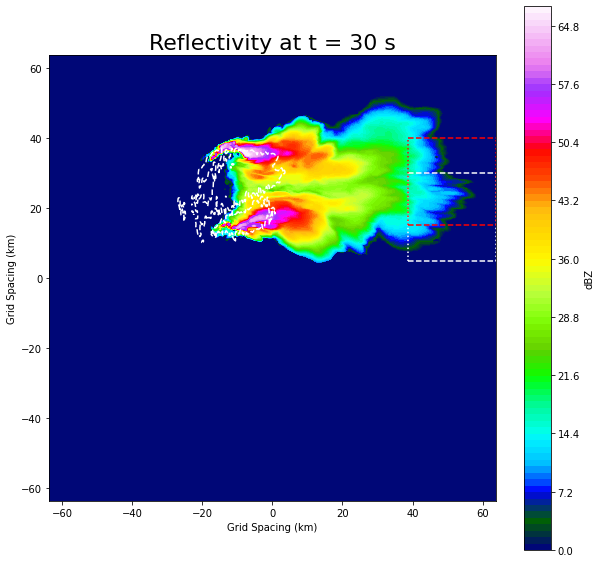

In [57]:
#Create A Rough Image
#Fix Aspect Ratio
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

refl = plt.contourf(x_data,y_data,dbz_storm16[1][0].isel(nk = 20), levels=100, cmap ='gist_ncar')
pert = plt.contour(x_data,y_data, thpert_storm16[1][0][0]-Mean_th, levels = [-0.2], colors ='w')
#ncar color bar = gist_ncar
#Set Box Bounds
lower_bound_x, upper_bound_x = x_data[lower_bound_x],x_data[upper_bound_x]
lower_bound_y, upper_bound_y = y_data[lower_bound_y], y_data[upper_bound_y]

#Plot Box of Domain of Interest
#Plot horizontal lines for the top and bottom of the box
ax.plot([lower_bound_x, upper_bound_x], [lower_bound_y, lower_bound_y], color='w', linestyle='--')
ax.plot([lower_bound_x, upper_bound_x], [upper_bound_y, upper_bound_y], color='w', linestyle='--')

# Plot vertical lines for the left and right of the box
ax.plot([lower_bound_x, lower_bound_x], [lower_bound_y, upper_bound_y], color='w', linestyle=':')
ax.plot([upper_bound_x, upper_bound_x], [lower_bound_y, upper_bound_y], color='w', linestyle=':')

# Plot Original Box
ax.plot([x_data.max().values-25, x_data.max().values], [15, 15], color='r', linestyle='--')
ax.plot([x_data.max().values-25, x_data.max().values], [40, 40], color='r', linestyle='--')
ax.plot([x_data.max().values-25, x_data.max().values-25], [15, 40], color='r', linestyle=':')
ax.plot([x_data.max().values, x_data.max().values], [15, 40], color='r', linestyle=':')

plt.title(f"Reflectivity at t = 30 s", fontsize=22)
plt.colorbar(refl, label = 'dBZ')
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
ax.set_aspect('equal')

In [5]:
#Step 2: Reading Velocity Data 

#all files for storm 16
all_files = sorted(glob.glob(storm16_data_path+"*.nc"))

#remove the first file which is the initial field at t = 12 hrs and the outstatistics at the end
file_paths = all_files[1:-1]

# Manually open and extract the required variables from each dataset
velocities = []
for f in tqdm(file_paths):
    
    dataset = xr.open_dataset(f)[['uinterp', 'vinterp', 'winterp']]
    velocities.append(dataset)
    #except KeyError:
        #print(f"KeyError encountered while processing file: {f}")

100%|██████████| 120/120 [00:01<00:00, 61.33it/s]


In [6]:
#Attempt at Trajectories For Entire Grid 
#Remember to .values outside of for loop
#allocate storage for amount of  points along trajectory 
numtrajp = int((time[-1]-time[0])/dt)

#Create Array For First Level of Points: Instead of Points at Each Location, 
#stack them such that if there's N points over the grid, design it such that it's an array of dimensions (N,3)

points = np.zeros((numtrajp, horiz_length**2, 3))
counter = 0

#turn 
z_s = z_data.values
y_s = y_data.values
x_s = x_data.values


for y in tqdm(range(horiz_length)):
    for x in range(horiz_length):
        points[0][counter] = ( z_s[0]+1/1000, y_s[lower_bound_y+y],x_s[lower_bound_x + x])
        counter +=1

100%|██████████| 335/335 [00:00<00:00, 565.95it/s]


In [7]:
#Create a Function That Interpolates in Time (applicable to data that includes all times in it)
def interp_t(analtime, time, var):
    
    #Variable of Interest
    #var = var 
    
    #horizontal sheet of points of shape (335,335,3) (3 is defined as z,y,x)
    #points = points
    
    #array of all times 
    #time = time 
    
    #time which we are interpolating to
    #analtime = analtime
    
    
    #Find times that are before and after the interpolation time
    before_indices = np.where(time <= analtime)[0]
    after_indices = np.where(time >= analtime)[0]
    
   
    #raise an error if the time at which interpolation occurs lies outside of the time interval of data
    if len(before_indices) == 0 or len(after_indices) == 0:
        raise ValueError('analysis time lies outside of the time interval')
    
    #indices closest before & after the interpolation time
    Bindex = before_indices[-1]
    Aindex = after_indices[0]
    
    #if time we are interpolating is the same as one of the data timesteps, just return original data at that timestep
    if time[Bindex] == analtime:
        interp_data = var[Bindex].isel(time=0)
        return interp_data
    elif time[Aindex] == analtime:
        interp_data = var[Aindex].isel(time=0)
        return interp_data
    
    #Perform Linear Interpolation
    
    #saving as local variables cuts down on runtime
    before_data = var[Bindex][['uinterp', 'vinterp', 'winterp']].isel(time=0)
    after_data = var[Aindex][['uinterp', 'vinterp', 'winterp']].isel(time=0)
    
    interp_u = before_data['uinterp'].values +  (
        (after_data['uinterp'].values - 
         before_data['uinterp'].values) *
        (analtime - time[Bindex]) /
        (time[Aindex] - time[Bindex])
    )
    
    interp_v = before_data['vinterp'].values +  (
        (after_data['vinterp'].values - 
         before_data['vinterp'].values) *
        (analtime - time[Bindex]) /
        (time[Aindex] - time[Bindex])
    )
    
    interp_w = before_data['winterp'].values +  (
        (after_data['winterp'].values - 
         before_data['winterp'].values) *
        (analtime - time[Bindex]) /
        (time[Aindex] - time[Bindex])
    )
    
    dims = ('nk', 'nj', 'ni')
    
    #returns dataset of velocity fields in a small cloud based on the previous interpolation point to save computing resources/time
    return xr.Dataset({'uinterp': (dims,interp_u),'vinterp': (dims, interp_v),'winterp': (dims,interp_w)}, coords={'ni': ni,'nj': nj,'nk': nk});
    

In [8]:
#Create A Function That Interpolates in Space (COME BACK TO THIS)
def interp_s(points, var): #field):
    
     
    #horizontal sheet of points of shape (335x335,3) (3 is defined as z,y,x)
    #points = points
    
    #points at which to interpolate(decompose points argument into its components)
    xp = points[:,2]
    yp = points[:,1]
    zp = points[:,0]
    
    #all the scalar points in the domain for interpolation
    x = x_data.values
    y = y_data.values
    z = z_data.values
    
    # Apply periodic boundary conditions using np.where
    xp = np.where(xp > x.max(), xp - (x.max() - x.min()), xp) # right boundary
    xp = np.where(xp < x.min(), xp + (x.max() - x.min()), xp) # left boundary
    yp = np.where(yp > y.max(), yp - (y.max() - y.min()), yp) # top boundary
    yp = np.where(yp < y.min(), yp + (y.max() - y.min()), yp) # bottom boundary
                          
    #balloon floating out of domain condition 
    if np.any(zp > z.max()): 
        raise ValueError('Interp_s: Weather Sonde Has Left the Building :(')
        
    #recombine points after periodic condition
    new_points = np.zeros((points.shape[0], 3))
    new_points[:,0] = zp
    new_points[:,1] = yp
    new_points[:,2] = xp
        
    vel_u, vel_v, vel_w =  [var['uinterp'].values, var['vinterp'].values, var['winterp'].values]
    
    #Create Interpolation Functions
    interpolator_u = RegularGridInterpolator((z,y,x), vel_u)
    interpolator_v = RegularGridInterpolator((z,y,x), vel_v)
    interpolator_w = RegularGridInterpolator((z,y,x), vel_w)
    
    #Interpolate the velocities
    interp_u = interpolator_u(new_points)
    interp_v = interpolator_v(new_points)
    interp_w = interpolator_w(new_points)
    
    return interp_u, interp_v, interp_w; 
    
    
                

    
    

In [9]:
#Create A Function That Utililzes a 4th-Order Rubge-Kutta Scheme to Advance in Space
def rk4(old_points, dxdt, dydt, dzdt, analtime, time, dt, nanal, data):
    #previous points(in shape (335x335, 3))
    #old_points = old_points
    
    #previous velocity
    #old_u = old_dxdt
    #old_v = old_dydt
    #old_w - old_dzdt
    
    #array of all the times 
    #time = time
    
    #all recorded data at all times 
    #data = data
    
    #timestep
    #dt =dt 
    
    #current time where we are interpolating 
    #analtime = analtime 
    
    #total number of analysis times 
    #nanal = nanal 
    
    #create a storage array for the points
    pos = np.zeros(old_points.shape)
    
    #all the scalar points in the domain for interpolation
    x = x_data.values
    y = y_data.values
    z = z_data.values
    
    #relevant timesteps
    hh = dt*0.5 #Half Timestep
    h6 = dt/6 #1/6 Timestep
    th = analtime + hh #half timestep forward
    
    
    #FIRST INTERMEDIATE STEP
    #progress in space
    pos[:,2] = old_points[:,2] + hh*dxdt*.001 #change x-coordinates
    pos[:,1] = old_points[:,1] + hh*dydt*.001 #change y-coordinates
    pos[:,0] = old_points[:,0] + hh*dzdt*.001 #change z-coordinates
    
    # Apply periodic boundary conditions using np.where
    pos[:,1] = np.where(pos[:,1] > y.max(), pos[:,1] - (y.max() - y.min()), pos[:,1]) #periodic in y-direction (top-boundary)
    pos[:,1] = np.where(pos[:,1] < y.min(), pos[:,1] + (y.max() - y.min()), pos[:,1]) #periodic in y-direction (bottom boundary)
    pos[:,2] = np.where(pos[:,2] > x.max(), pos[:,2] - (x.max() - x.min()), pos[:,2]) #periodic in x-direction (right boundary)
    pos[:,2] = np.where(pos[:,2] < x.min(), pos[:,2] + (x.max() - x.min()), pos[:,2]) #periodic in x-direction (left boundary)
    #balloon floating out of domain condition 
    if np.all(pos[:,0]) > z.max():
        raise ValueError('RK4: Weather Sonde Has Left the Building :(')
    
    #interpolate in time
    velocity = interp_t(th, time, velocities)
    #u = velocity['uinterp']
    #v = velocity['vinterp']
    #w = velocity['winterp']
    
    #interpolate velocity in space based on new position (xt,yt,zt)
    dxdt2, dydt2, dzdt2 = interp_s(pos,velocity)
    dzdt2 = dzdt2 + asc_rate
    
    #SECOND INTERMEDIATE STEP
    #progress in space
    pos[:,2] = old_points[:,2] + hh*dxdt2*.001 #change x-coordinates
    pos[:,1] = old_points[:,1] + hh*dydt2*.001 #change y-coordinates
    pos[:,0] = old_points[:,0] + hh*dzdt2*.001 #change z-coordinates
    
    # Apply periodic boundary conditions using np.where
    pos[:,1] = np.where(pos[:,1] > y.max(), pos[:,1] - (y.max() - y.min()), pos[:,1]) #periodic in y-direction (top-boundary)
    pos[:,1] = np.where(pos[:,1] < y.min(), pos[:,1] + (y.max() - y.min()), pos[:,1]) #periodic in y-direction (bottom boundary)
    pos[:,2] = np.where(pos[:,2] > x.max(), pos[:,2] - (x.max() - x.min()), pos[:,2]) #periodic in x-direction (right boundary)
    pos[:,2] = np.where(pos[:,2] < x.min(), pos[:,2] + (x.max() - x.min()), pos[:,2]) #periodic in x-direction (left boundary)
    #balloon floating out of domain condition 
    if np.all(pos[:,0]) > z.max():
        raise ValueError('RK4: Weather Sonde Has Left the Building :(')
    
    #interpolate in time
    velocity = interp_t(th, time, velocities)
    #u = velocity['uinterp']
    #v = velocity['vinterp']
    #w = velocity['winterp']
    
    #interpolate velocity in space based on new position (xt,yt,zt)
    dxdt3, dydt3, dzdt3 = interp_s(pos,velocity)
    dzdt3 = dzdt3 + asc_rate
    
    #FINAL STEP
    #progress in space again
    pos[:,2] = old_points[:,2] + dt*dxdt3*.001 #change x-coordinates
    pos[:,1] = old_points[:,1] + dt*dydt3*.001 #change y-coordinates
    pos[:,0] = old_points[:,0] + dt*dzdt3*.001 #change z-coordinates
    
    # Apply periodic boundary conditions using np.where
    pos[:,1] = np.where(pos[:,1] > y.max(), pos[:,1] - (y.max() - y.min()), pos[:,1]) #periodic in y-direction (top-boundary)
    pos[:,1] = np.where(pos[:,1] < y.min(), pos[:,1] + (y.max() - y.min()), pos[:,1]) #periodic in y-direction (bottom boundary)
    pos[:,2] = np.where(pos[:,2] > x.max(), pos[:,2] - (x.max() - x.min()), pos[:,2]) #periodic in x-direction (right boundary)
    pos[:,2] = np.where(pos[:,2] < x.min(), pos[:,2] + (x.max() - x.min()), pos[:,2]) #periodic in x-direction (left boundary)
    #balloon floating out of domain condition 
    if np.all(pos[:,0]) > z.max():
        raise ValueError('RK4: Weather Sonde Has Left the Building :(')
    
    #New Velocity Field
    dxdt3 = dxdt2 + dxdt3
    dydt3 = dydt2 + dydt3
    dzdt3 = dzdt2 + dzdt3
    
    #interpolate in time
    velocity = interp_t(analtime+dt, time, velocities)
    #u = velocity['uinterp']
    #v = velocity['vinterp']
    #w = velocity['winterp']
    
    #interpolate velocity in space based on new position (xt,yt,zt)
    dxdt2, dydt2, dzdt2 = interp_s(pos,velocity)
    dzdt2 = dzdt2 + asc_rate
    
    #New Points
    new_pos = np.zeros(old_points.shape)
    new_pos[:,2] = old_points[:,2] + h6 * (dxdt + dxdt2 + 2 * dxdt3) * 0.001
    new_pos[:,1] = old_points[:,1] + h6 * (dydt + dydt2 + 2 * dydt3) * 0.001
    new_pos[:,0] = old_points[:,0] + h6 * (dzdt + dzdt2 + 2 * dzdt3) * 0.001
    
    # Apply periodic boundary conditions using np.where
    new_pos[:,1] = np.where(new_pos[:,1] > y.max(), new_pos[:,1] - (y.max() - y.min()), new_pos[:,1]) #periodic in y-direction (top boundary)
    new_pos[:,1] = np.where(new_pos[:,1] < y.min(), new_pos[:,1] + (y.max() - y.min()), new_pos[:,1]) #periodic in y-direction (bottom boundary)
    new_pos[:,2] = np.where(new_pos[:,2] > x.max(), new_pos[:,2] - (x.max() - x.min()), new_pos[:,2]) #periodic in x-direction (right boundary)
    new_pos[:,2] = np.where(new_pos[:,2] < x.min(), new_pos[:,2] + (x.max() - x.min()), new_pos[:,2]) #periodic in x-direction (left boundary)
   
    #balloon floating out of domain condition 
    if np.all(new_pos[:,0]) > z.max():
        raise ValueError('RK4: Weather Sonde Has Left the Building :(')
        
    return new_pos;
    


In [10]:
#Attempt at Trajectories

#allocate storage for amount of points along trajectory 
numtrajp = int((time[-1]-time[0])/dt)
uhodo_tmp = np.zeros((numtrajp, horiz_length**2))
vhodo_tmp = np.zeros((numtrajp, horiz_length**2))
whodo_tmp = np.zeros((numtrajp, horiz_length**2))
trajpt = 1
badflag = 0

interp_points = np.zeros((numtrajp, horiz_length**2,3))

for t in tqdm(range(time[0], time[-1], dt)):
    #interpolate velocity to time = t 
    velo = interp_t(t, time,velocities)

    #trajectory points
    interp_points = points[trajpt-1]

    #interpolate to (xtmp, ytmp, ztmp)
    up, vp, wp = interp_s(interp_points, velo)
    wp = wp + asc_rate
    
    #store velocity for hodographs 
    #if trajpt == 1:
        #uhodo_tmp[0] = up
        #vhodo_tmp[0] = vp
    #else:
    uhodo_tmp[trajpt-1] = up #1000 * (xp[trajpt] - xp[trajpt - 1]) / dt
    vhodo_tmp[trajpt-1] = vp #1000 * (yp[trajpt] - yp[trajpt - 1]) / dt
    whodo_tmp[trajpt-1] = wp
        
    #checkpoint: print current state of trajectory
    #print(f'time = {t} s. \nsonde coordinates: {xtmp}, {ytmp}, {ztmp}')
    
    #if t == 2820:
        #flag = velo
            
    #check if we have risen above highest zlevel: break from loop if so
    if np.any(interp_points[:,0]) >= float(z_data.max()):
        break
    
    #check if we reached the highest point in the previous step
    if trajpt == len(points):
        break 
        
    #use runge-kutta-4th order scheme to advance the sonde in space    
    points[trajpt] = rk4(interp_points, up, vp, wp, t, time, dt, nanal, velocities)
    
    #advance trajectory counter
    trajpt += 1
    

               

 98%|█████████▊| 351/357 [3:14:32<03:19, 33.26s/it]  


ValueError: Interp_s: Weather Sonde Has Left the Building :(

#The trajectories cell above will compute trajectories for all points 
#until one point reaches the top of the domain. 

#need to figure out the index where the code stops


In [11]:
#Find the Point where the code stops
index = 0
for t in tqdm(range(time[0], time[-1], dt)):
    if np.any(points[index][:,0]) == 0.0:
        breakpoint = index  #point where the trajectories stops+1
        break
    index += 1




 99%|█████████▊| 352/357 [00:00<00:00, 3082.98it/s]


In [13]:
points[breakpoint]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [14]:
#Create a Top Down View of the Trajectory Path of All Weather Sondes

path = '/storage/work/bsh5393/Variability Study/Sensitivity Analysis/Figures/'
gifname = '/storage/work/bsh5393/Variability Study/Sensitivity Analysis/topdowngridtraj.gif'

fig = plt.figure(figsize = (9.6,7.2))
ax = fig.add_subplot(111)

for x in tqdm(np.arange(0, breakpoint, 1)):
    image_filename = "figure_%03d.png" % (x)
    plt.scatter(points[x,:,2], points[x,:,1], c = 'b')
    plt.title(f"Top Down Trajectory Full Grid. t = {int_time[x]} s")
    plt.xlim(x_data.min(), x_data.max())
    plt.ylim(y_data.min(), y_data.max())
    fig.savefig(path+image_filename)
    plt.clf()

100%|██████████| 352/352 [01:40<00:00,  3.50it/s]


<Figure size 691.2x518.4 with 0 Axes>

In [15]:
#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.05
end_interval = 1.0

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
#imagefiles.remove('.ipynb_checkpoints')


image_filenames = []

for image_filename in imagefiles:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

100%|██████████| 111556/111556 [01:16<00:00, 1462.79it/s]


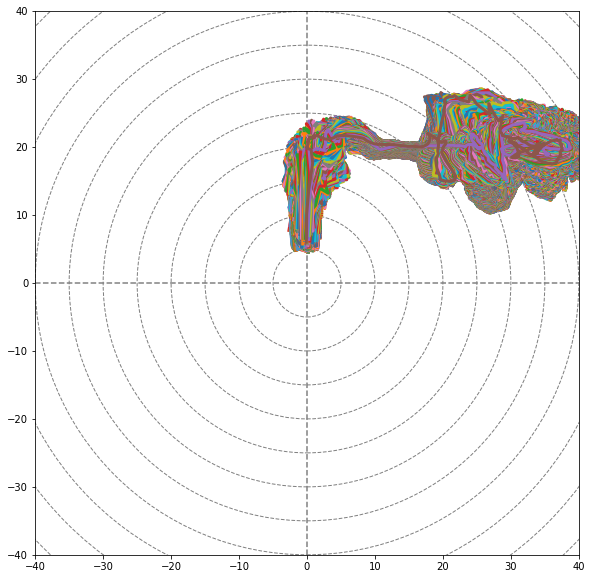

In [16]:
#Create Hodographs

offset_u = 12.2
offset_v = 12.5
fig, ax = plt.subplots(figsize = (10,10))
h = metpy.plots.Hodograph(ax, component_range=40.)
h.add_grid(increment=5)

for i in tqdm(range(334*334)):
    h.plot(uhodo_tmp[:breakpoint,i]+offset_u, vhodo_tmp[:breakpoint,i]+offset_v)

100%|██████████| 352/352 [07:56<00:00,  1.35s/it]


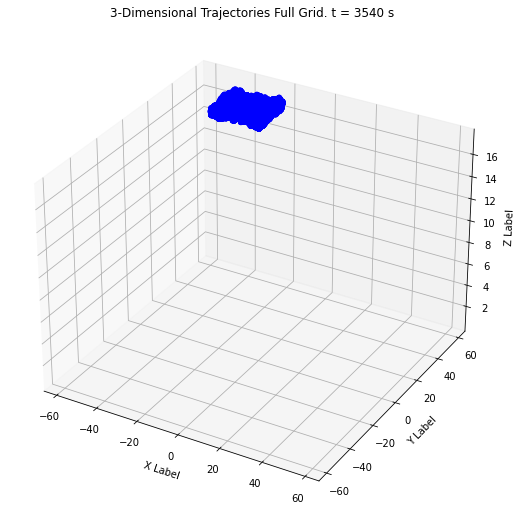

In [17]:
# Create 3 dimensional trajectory gif
# Path to save images and gif
path = '/storage/work/bsh5393/Variability Study/Sensitivity Analysis/Figures/'
gifname = '/storage/work/bsh5393/Variability Study/Sensitivity Analysis/3Dgridtraj.gif'

# Create a figure and a 3D axis
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, projection='3d')

for x in tqdm(np.arange(0, breakpoint, 1)):
    image_filename = "figure_%03d.png" % (x)
    
    # Clear the 3D axis
    ax.collections.clear()  
    
    # Plot the points
    ax.scatter(points[x,:,2], points[x,:,1], points[x,:,0], c='b', marker='o')
    
    # Set the title and axis limits
    ax.set_title(f"3-Dimensional Trajectories Full Grid. t = {int_time[x]} s")
    ax.set_xlim(x_data.min(), x_data.max())
    ax.set_ylim(y_data.min(), y_data.max())
    ax.set_zlim(z_data.min(), z_data.max())  # Add this line to set z limits if needed

    # Set labels for the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    # Save the figure
    fig.savefig(path + image_filename)

In [18]:
#These variables control the time step (interval) and the length of the pause at the end of the animation (end_interval)
interval = 0.05
end_interval = 1.0

#gifname = '/storage/work/bsh5393/Variability Study/Data/InterpolationData/Revised3Dgridtraj.gif'

#Iterating through all of the files in path, and then sorting the filenames
imagefiles = os.listdir(path)
#imagefiles.remove('.ipynb_checkpoints')
#imagefiles.remove('trajectory.gif')
#imagefiles.remove('gridtraj.gif')

image_filenames = []

for image_filename in imagefiles:
    image_filenames.append(image_filename)
image_filenames.sort()
    
#Opening each image file and saving it to a list
images = []
for image_filename in image_filenames:
    images.append(imageio.imread(path + image_filename))
      
#Generating an array containing the duration to display each frame
durations = np.ones(len(images))*interval
durations[-1] = end_interval

#Generating the animation itself
imageio.mimsave(gifname, images, duration = durations.tolist())

In [19]:
#Save Trajectories Positions and Velocities

path = '/storage/work/bsh5393/Variability Study/Sensitivity Analysis/Data/'


# Save arrays to .npz file
np.savez(path+'rawtrajectories.npz', interp_points=points, interp_u=uhodo_tmp, interp_v = vhodo_tmp, interp_w = whodo_tmp)

# Load arrays from .npz file
#data = np.load(path+'rawtrajectories.npz')
#points = data['interp_points']
#loaded_array2 = data['array2']


In [47]:
points.shape

(357, 111556, 3)